# Evaluate Model
This notebooks loads a specific model so that you can evaluate it.

In [1]:
import sys
sys.path.insert(0, '../')

import math
import torch
import numpy as np
import pylab as plt

from models import build_model
from datasets import build_dataset, build_ood_datasets
from metrics import calibration, ood, generalization
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load checkpoint
checkpoint = torch.load('../results/CIFAR10__wideresnet2810_sngp/seed5/model_final.pth')
args = checkpoint['args']
args.dataset_path = '../data'

# Loading model
model_dict = build_model(args, n_classes=10, train_ds=None)
model = model_dict['model']
model(torch.randn(1, 3, 32, 32))
model.load_state_dict(checkpoint['model'])

# Load datasets
train_ds, test_ds, ds_info = build_dataset(args)
ood_datasets = build_ood_datasets(args, ds_info['mean'], ds_info['std'])
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, sampler=None)# range(1000))
ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=256, sampler=None)# range(1000))
checkpoint['test_history'][-1]

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat


{'test_acc1': 96.30999755859375,
 'test_prec': 0.9630582252113501,
 'test_loss': 0.12493996322154999,
 'test_nll': 0.12493996322154999,
 'test_tce': 0.0053497073240578175,
 'test_mce': 0.017074255272746086,
 'test_SVHN_entropy_auroc': 0.9490263905961893,
 'test_SVHN_conf_auroc': 0.942609870543946,
 'test_SVHN_entropy_aupr': 0.9733093056804468,
 'test_SVHN_conf_aupr': 0.9680855410818268}

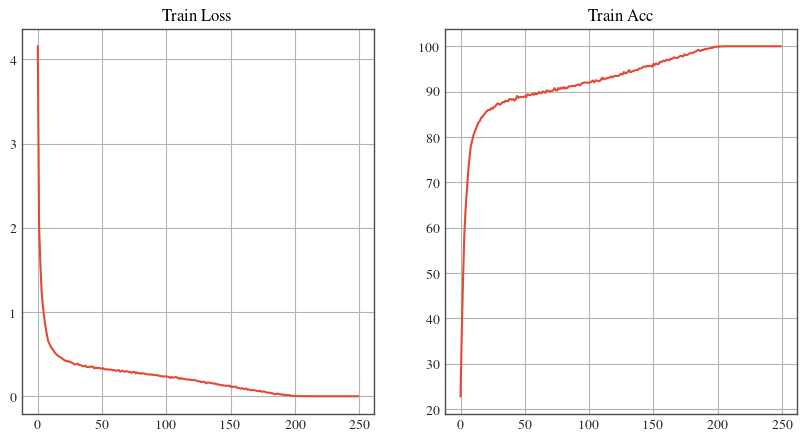

In [5]:
train_history = checkpoint['train_history']
plt.subplot(121)
plt.title('Train Loss')
plt.plot([d['train_loss'] for d in train_history])

plt.subplot(122)
plt.title('Train Acc')
plt.plot([d['train_acc1'] for d in train_history])

In [6]:
# forward prop
def mean_field_logits(logits, cov, lmb=math.pi / 8):
    """Scale logits using the mean field approximation proposed by https://arxiv.org/abs/2006.07584"""
    if lmb is None or lmb < 0:
        return logits
    variances = torch.diag(cov).view(-1, 1) if cov is not None else 1
    logits_adjusted = logits / torch.sqrt(1 + lmb*variances)
    return logits_adjusted

mff = 75
device = 'cuda'
model.to(device)
model.eval()

logits, targets = [], []
for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        logits_, cov = model(inp.to(device), return_cov=True)
        logits.append(mean_field_logits(logits_, cov, lmb=mff).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

logits_ood = []
for inp, tar in tqdm(ood_loader):
    with torch.no_grad():
        logits_, cov = model(inp.to(device), return_cov=True)
        logits_ood.append(mean_field_logits(logits_, cov, lmb=mff).cpu())
logits_ood = torch.cat(logits_ood)

100%|██████████| 102/102 [00:19<00:00,  5.25it/s]


In [7]:
# Compute results
entropy_id = ood.entropy_fn(logits.softmax(-1))
entropy_ood = ood.entropy_fn(logits_ood.softmax(-1))
tce_criterion = calibration.TopLabelCalibrationError()
nll_criterion = torch.nn.CrossEntropyLoss()

results = {
    'ACC': generalization.accuracy(logits, targets)[0].item(),
    'TCE': tce_criterion(logits.softmax(-1), targets).item(),
    'NLL': nll_criterion(logits, targets).item(),
    'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
}
print(results)

{'ACC': 96.30999755859375, 'TCE': 0.005192078649997711, 'NLL': 0.12494001537561417, 'AUROC': 0.9490291852335588}


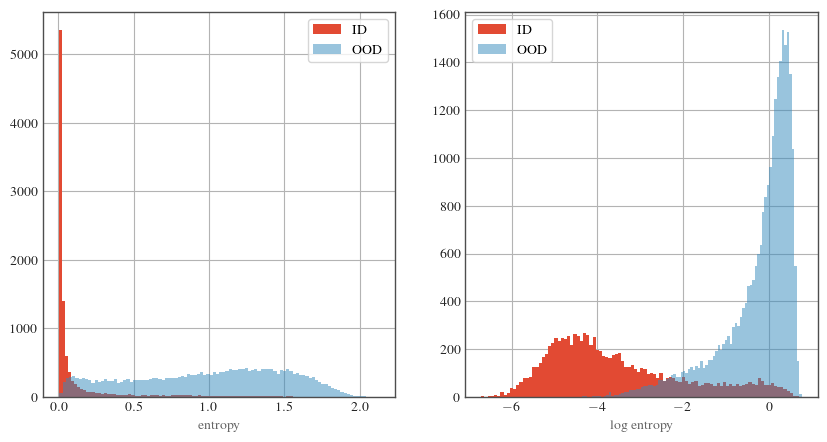

In [8]:
# Plot ood histogram
plt.subplot(121)
plt.hist(entropy_id, bins=100, label='ID')
plt.hist(entropy_ood, bins=100, alpha=.5, label='OOD')
plt.xlabel('entropy')

plt.legend()
plt.subplot(122)
plt.hist(entropy_id.log(), bins=100, label='ID')
plt.hist(entropy_ood.log(), bins=100, alpha=.5, label='OOD')
plt.xlabel('log entropy')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

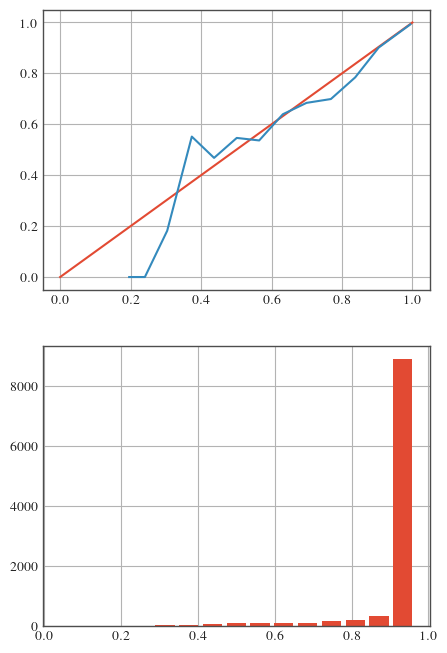

In [9]:
# Plot reliability diagram
tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)

In [18]:
results = []
mean_field_factors = np.linspace(1, 200, 100)

# forward prop
device = 'cuda'
model.to(device)
model.eval()

logits = {mean_field_factor: [] for mean_field_factor in mean_field_factors}
targets = []

for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        targets.append(tar)
        logits_, cov = model(inp.to(device), return_cov=True)
        for mff in mean_field_factors:
            logits_scaled = mean_field_logits(logits_, cov, lmb=mff).cpu()
            logits[mff].append(logits_scaled)

logits = {mff: torch.cat(l) for mff, l in logits.items()}
targets = torch.cat(targets)

logits_ood = {mean_field_factor: [] for mean_field_factor in mean_field_factors}
for inp, _ in tqdm(ood_loader):
    with torch.no_grad():
        logits_, cov = model(inp.to(device), return_cov=True)
        for mff in mean_field_factors:
            logits_scaled = mean_field_logits(logits_, cov, lmb=mff).cpu()
            logits_ood[mff].append(logits_scaled)
logits_ood = {mff: torch.cat(l) for mff, l in logits_ood.items()}

results = []
for mff in mean_field_factors:
    l_id, l_ood = logits[mff], logits_ood[mff]

    # Compute results
    entropy_id = ood.entropy_fn(l_id.softmax(-1))
    entropy_ood = ood.entropy_fn(l_ood.softmax(-1))
    tce_criterion = calibration.TopLabelCalibrationError()
    nll_criterion = torch.nn.CrossEntropyLoss()

    result_dict = {
        'ACC': generalization.accuracy(l_id, targets)[0].item(),
        'TCE': tce_criterion(l_id.softmax(-1), targets).item(),
        'NLL': nll_criterion(l_id, targets).item(),
        'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
    }
    results.append(result_dict)
    print(result_dict)

100%|██████████| 102/102 [00:20<00:00,  5.10it/s]


{'ACC': 96.30999755859375, 'TCE': 0.01902412436902523, 'NLL': 0.14339017868041992, 'AUROC': 0.9125235133681623}
{'ACC': 96.30999755859375, 'TCE': 0.0187147818505764, 'NLL': 0.14197036623954773, 'AUROC': 0.915565876613399}
{'ACC': 96.30999755859375, 'TCE': 0.01849844865500927, 'NLL': 0.14065365493297577, 'AUROC': 0.918278561001844}
{'ACC': 96.30999755859375, 'TCE': 0.018322357907891273, 'NLL': 0.13943013548851013, 'AUROC': 0.9207175072987095}
{'ACC': 96.30999755859375, 'TCE': 0.0180527251213789, 'NLL': 0.13829143345355988, 'AUROC': 0.9229101663337431}
{'ACC': 96.30999755859375, 'TCE': 0.01775425486266613, 'NLL': 0.13723021745681763, 'AUROC': 0.9249008796865397}
{'ACC': 96.30999755859375, 'TCE': 0.017482325434684753, 'NLL': 0.13624024391174316, 'AUROC': 0.9267101951444375}
{'ACC': 96.30999755859375, 'TCE': 0.01656951755285263, 'NLL': 0.13531605899333954, 'AUROC': 0.9283600510909651}
{'ACC': 96.30999755859375, 'TCE': 0.01636464335024357, 'NLL': 0.1344527304172516, 'AUROC': 0.9298678741548

: 

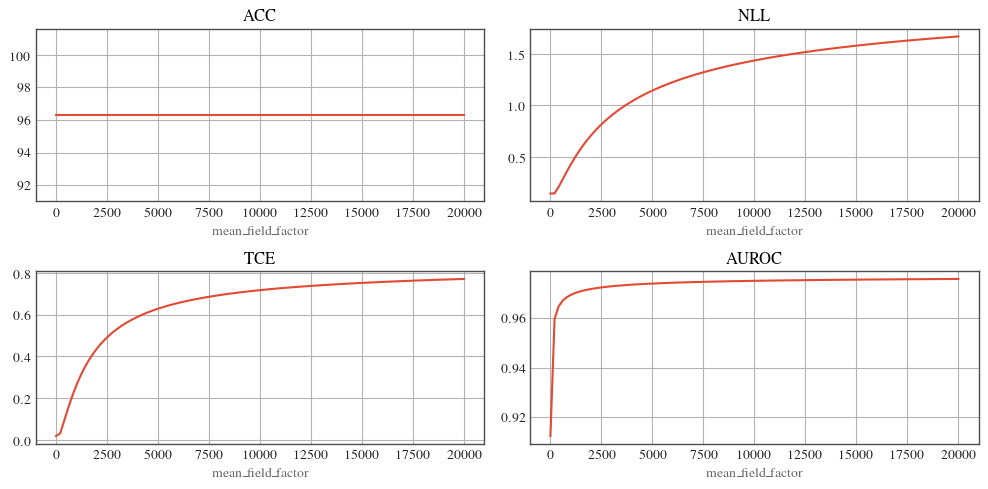

In [17]:
plt.subplot(221)
plt.title('ACC')
plt.plot(mean_field_factors, [d['ACC'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(222)
plt.title('NLL')
plt.plot(mean_field_factors, [d['NLL'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(223)
plt.title('TCE')
plt.plot(mean_field_factors, [d['TCE'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(224)
plt.title('AUROC')
plt.plot(mean_field_factors, [d['AUROC'] for d in results])
plt.xlabel('mean_field_factor')

plt.tight_layout()
plt.show()